In [2]:
"""
Extinguisher.ipynb
TODO:
- [x] Get floor definition from Revit
- [x] Add Obstacles
- [ ] Add Doors (extinguisher to be closest to access points)
"""
__author__ = "Bob YX Lee"
import sys 
import os
import json
import drawsvg as dw
import random
from copy import deepcopy

sys.path.append("./packages")

from geom.Line2D import Line2D

MM = 100

data = {}
# Get random data point
datafiles = os.listdir("./dataset")
data_path = os.path.join("./dataset", "room_payload.json")
data = {}
with open(data_path, "r") as f:
    data = json.loads(f.read())

d = dw.Drawing(1200, 480, origin = (-MM*4, -MM*2), id_prefix='pic')
dpath = dw.Path(stroke = 'black', fill = 'lightgray')
#print(data)
surface = data["surface"]
floor_lines = []
surface["room"].append(surface["room"][0])

for i, p in enumerate(surface["room"]):
    
    if i == 0: 
        dpath.M(p[0]/MM, -p[1]/MM)
        p1 = (surface["room"][0])
        p2 = (surface["room"][1])
        floor_lines.append(Line2D(p1, p2))
        continue
    dpath.L(p[0]/MM, -p[1]/MM)
    if len(surface["room"]) - 1 == i: break
    p1 = (surface["room"][i])
    p2 = (surface["room"][i+1])
    floor_lines.append(Line2D(p1, p2))
    pass

obstacle_lines = []
for i,b in enumerate(surface["obstacles"]):
    b.append(b[0])
    for n,p in enumerate(b):
        if n == 0: 
            dpath.M(p[0]/MM, -p[1]/MM); 
            p1 = (surface["obstacles"][i][0])
            p2 = (surface["obstacles"][i][1])
            obstacle_lines.append(Line2D(p1, p2))    
            continue
        dpath.L(p[0]/MM, -p[1]/MM)
        if len(surface["obstacles"][i]) - 1 == n: break
        obstacle_lines.append(Line2D(surface["obstacles"][i][n], surface["obstacles"][i][n+1]))
    pass

d.append(dpath)


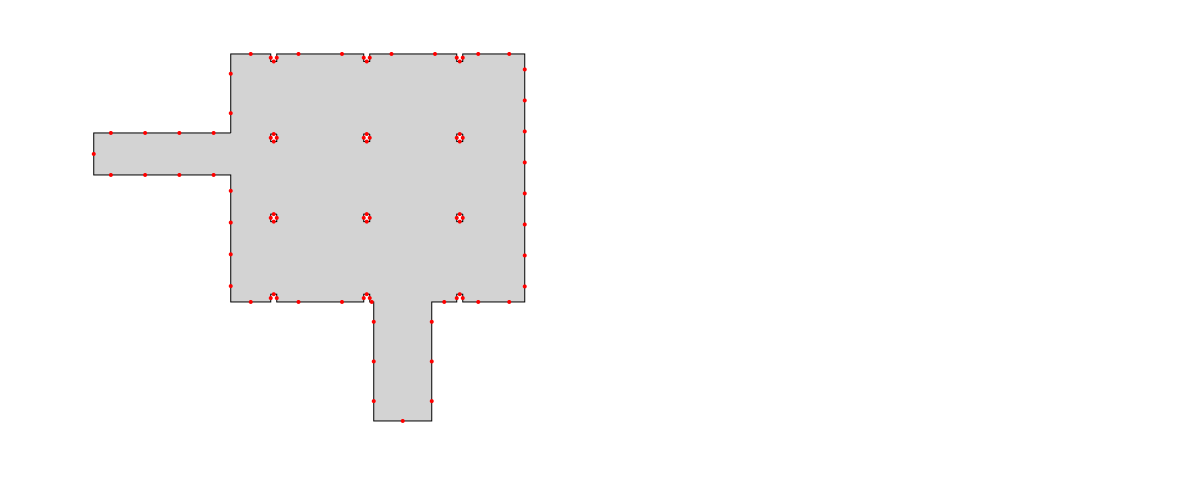

In [3]:
# Split into midpoints
floor_mids = []
div_len = 3000
for l in floor_lines:
    if l.length < div_len:
        floor_mids.append(l.mid)
        continue
    divs = l.divideByLength(div_len)
    floor_mids.extend([s.mid for s in divs])

obstacle_mids = []
for l in obstacle_lines:
    if l.length < div_len:
        obstacle_mids.append(l.mid)
        pass
    pass

d2 = deepcopy(d)

# Show possible extinguisher placements
for m in obstacle_mids:
    d2.append(dw.Circle(m[0]/MM, -m[1]/MM, 2, fill='red'))
for m in floor_mids:
    d2.append(dw.Circle(m[0]/MM, -m[1]/MM, 2, fill='red'))
d2

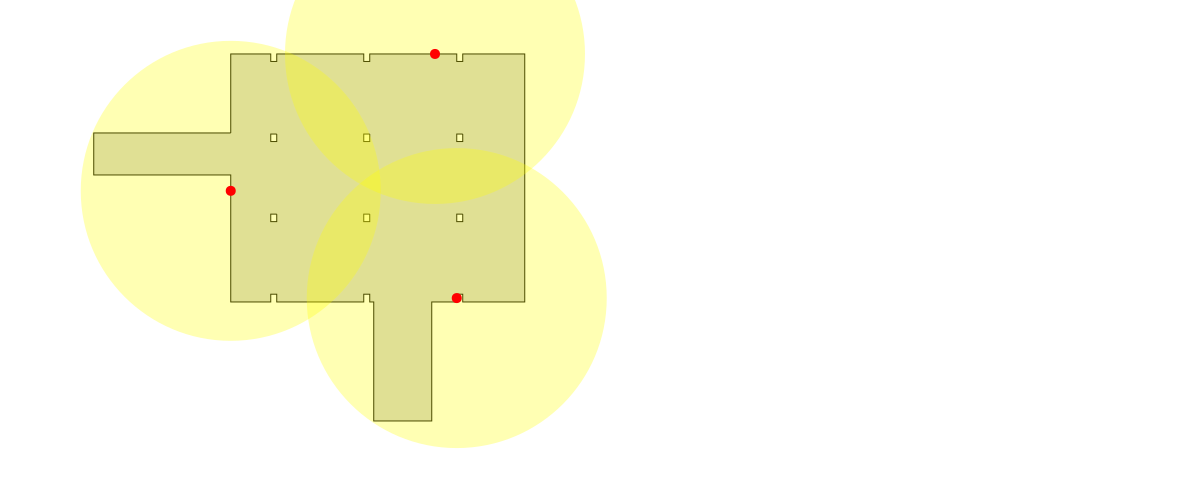

In [8]:
"""
PASS 1
TODO:
- Create iteration algorithm
"""
# Iterate through all possible combinations until boolean difference is 0
d3 = deepcopy(d)

def drawCoverage(d, pt):
    d.append(dw.Circle(pt[0]/MM, -pt[1]/MM, 15000/MM, fill='yellow', fill_opacity=0.3))
    d.append(dw.Circle(pt[0]/MM, -pt[1]/MM, 5, fill='red'))
    pass

tp = floor_mids[9]
tp1 = floor_mids[31]
tp2 = floor_mids[49]
drawCoverage(d3, tp)
drawCoverage(d3, tp1)
drawCoverage(d3, tp2)

d3

[[[3174, -16339], [2995, -16275], [2374, -15982], [1785, -15628], [1233, -15219], [724, -14758], [263, -14249], [-146, -13697], [-499, -13108], [-793, -12487], [-1024, -11840], [-1191, -11174], [-1292, -10494], [-1325, -9808], [-1292, -9122], [-1191, -8443], [-1024, -7776], [-793, -7129], [-499, -6508], [-146, -5919], [263, -5367], [724, -4858], [1233, -4397], [1785, -3988], [2374, -3635], [2995, -3341], [3642, -3110], [4308, -2943], [4988, -2842], [5674, -2808], [6360, -2842], [7039, -2943], [7706, -3110], [8352, -3341], [8973, -3635], [9563, -3988], [10114, -4397], [10623, -4858], [11085, -5367], [11494, -5919], [11847, -6508], [12141, -7129], [12372, -7776], [12474, -8183], [12474, 14603], [10499, 14603], [10465, 13917], [10364, 13238], [10197, 12571], [9966, 11925], [9672, 11304], [9319, 10714], [8910, 10163], [8448, 9654], [7939, 9192], [7388, 8783], [6798, 8430], [6177, 8136], [5531, 7905], [4864, 7738], [4185, 7637], [3499, 7603], [2813, 7637], [2133, 7738], [1467, 7905], [820, 

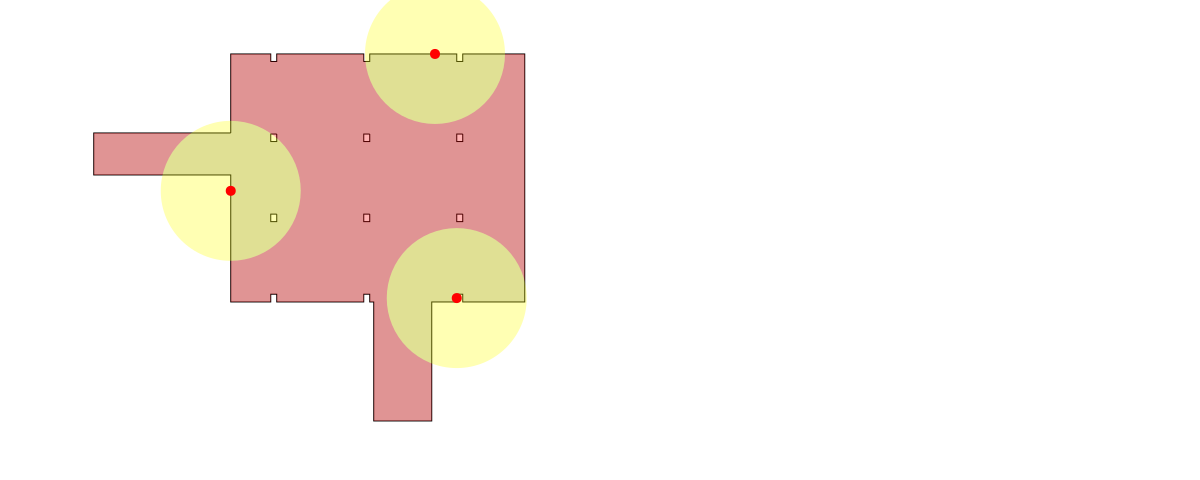

In [7]:
"""
Test pyclipper
"""
import numpy as np
import pyclipper

def polyArea(path):
    if len(path == 0): return 0
    x = np.array([point[0] for point in path])
    y = np.array([point[1] for point in path])
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1))) 

def drawPath(dwg, path, fill="yellow", fill_opacity = 0.3):
    dpath = dw.Path(fill = fill, fill_opacity = fill_opacity)
    for i, v in enumerate(path):
        if i == 0: dpath.M(v[0]/MM, -v[1]/MM); continue;
        dpath.L(v[0]/MM, -v[1]/MM)
    dwg.append(dpath)

def circle2D(radius, nv, center = (0,0), endpoint = False):
    theta = np.linspace(0, 2 * np.pi, nv, endpoint=endpoint)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)

    vertices = np.vstack((x,y)).T
    moved_verts = []
    for v in vertices:
        moved_verts.append((v[0]+center[0], v[1] + center[1]))
    return moved_verts

boundary = surface["room"]
boundary2d = []
for b in boundary:
    boundary2d.append((b[0], b[1]))

circle = circle2D(15000, 64, tp)
circle2 = circle2D(15000, 64, tp1)
circle3 = circle2D(15000, 64, tp2)
d5 = deepcopy(d3)
pc = pyclipper.Pyclipper()
pc.AddPaths([circle2, circle, circle3], pyclipper.PT_CLIP, True)

pc.AddPath(boundary2d, pyclipper.PT_SUBJECT, True)
sln = pc.Execute(pyclipper.CT_DIFFERENCE, pyclipper.PFT_POSITIVE, pyclipper.PFT_POSITIVE)
print(sln)
pass1 = False
for p in sln:
    drawPath(d5, p, "red")
    print(polyArea(p))
if(len(sln) == 0):
    pass1 = True
    print("Pass 1: PASSED")
d5

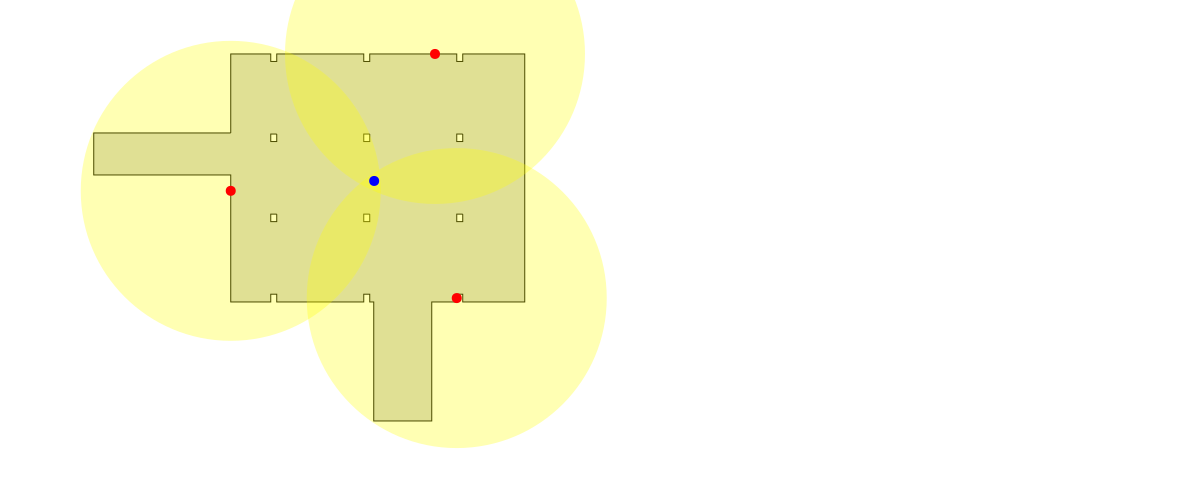

In [12]:
"""
Find the most remote point
If only 1 point, get point along wall furthest from the point
Otherwise, get average of all points
"""
def drawPt(d, pt):
    d.append(dw.Circle(pt[0]/MM, -pt[1]/MM, 5, fill='blue'))
    pass

def furthest(point, others):
    others = np.array(others)
    distances = np.linalg.norm(point - points, axis = 1)
    furthest_idx = np.argmax(distances)
    return points[furthest_idx]

def most_remote(points = [], bounding = []):
    if len(points) == 1: return furthest(points[0], bounding);
    else: return np.mean(points, axis = 0)

all_bounds = floor_mids + obstacle_mids
extinguishers = [tp, tp1, tp2]
rp = most_remote(extinguishers, all_bounds)
d6 = deepcopy(d5)
drawPt(d6, rp)

d6

Pass 2: PASS


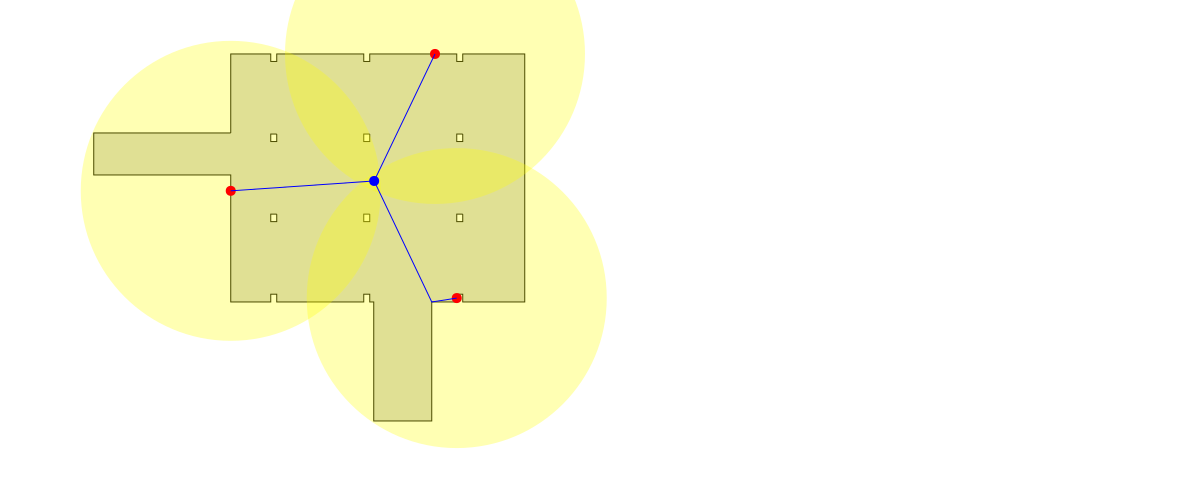

In [13]:
"""
PASS 2
- Make sure fire-route server is on!
- [x] Send navmesh
- [ ] Render shortest path
"""
import re
import requests
from geom.Line2D import distance2D

FIRE_ROUTE = "http://localhost:41982/travel"

def pathLength(path):
    dist = 0
    for i, l, in enumerate(path):
        if i == len(path) - 1: continue
        dist += distance2D(l, path[i+1])
        pass
    return dist

def drawTravel(drawing, start, end, stroke = "blue", failstroke = "orange", fill="none"):
    mesh = data["navmesh"]
    start = list(start[0:2])
    end = list(end[0:2])
    #print(start)
    payload = {"mesh": mesh, "start":start, "end": end}
    res = requests.post(FIRE_ROUTE, json = payload)

    travel = res.json()["result"]
    #print(res.json())
    distance = pathLength(travel)
    if(distance > 15000): stroke = failstroke
    tpath = dw.Path(stroke = 'blue', fill = 'none')
    for i, p in enumerate(travel):
        if(i == 0): tpath.M(p[0]/MM, -p[1]/MM); continue
        tpath.L(p[0]/MM, -p[1]/MM)
        pass
    drawing.append(tpath)
    return pathLength(travel)

d4 = deepcopy(d6)
tps = [tp, tp1, tp2]
pass2 = False
for pt in tps:
    dist = drawTravel(d4, pt, rp)
    if dist > 15000: pass2 = True
    pass

if pass2 == True:
    print("Pass 2: PASS")
else:
    print("Pass 2: FAIL")

d4

In [14]:
"""
Verdict
"""
if (pass1 == True and pass2 == True):
    print("Extinguisher placement PASSES")
else:
    print("Extinguisher placement FAILS")

Extinguisher placement PASSES
